<a href="https://colab.research.google.com/github/HNXJ/QMC/blob/master/ProjectI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image captioning

With PyTorch CNN-Encoder and LSTM-Decoder

Hamed Nejat (96102578)

Deep learning course (Msc) Sharif university of technology - Prof.Fatemizadeh

# O. Download dataset

In this cell, the dataset images files are downloaded and unzipped to root. if you are running colab, uncomment first line to install wget.

In [2]:
!pip install wget
import wget
import zipfile

folder_path = 'Dataset/'
wget.download("http://images.cocodataset.org/zips/val2017.zip")
# wget.download("http://images.cocodataset.org/zips/test2015.zip")
# wget.download("http://images.cocodataset.org/annotations/image_info_test2014.zip")
with zipfile.ZipFile("val2017.zip", 'r') as zip_ref:
    zip_ref.extractall(folder_path)
# with zipfile.ZipFile("image_info_test2014.zip", 'r') as zip_ref:
#     zip_ref.extractall(folder_path)

wget.download('https://github.com/HNXJ/QMC/raw/master/captions.json', out=folder_path)
wget.download('https://github.com/HNXJ/QMC/raw/master/categories_info.json', out=folder_path)
wget.download('https://github.com/HNXJ/QMC/raw/master/images_info.json', out=folder_path)
wget.download('https://github.com/HNXJ/QMC/raw/master/labels.json', out=folder_path)

print("All files are downloaded to " + folder_path)

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=bad3e708fca58ea0093fcf984cdd9202b4fc57bf576750b612721deee84f4b39
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
All files are downloaded to Dataset/


In [3]:
root = "Dataset/annotations/"
with open(root + 'image_info_test2014.json') as f:
    captions_json = json.load(f)
# with open(root + 'labels.json') as f:
#     labels_json = json.load(f)

# with open(root + 'categories_info.json') as f:
#     categories_json = json.load(f)
# with open(root + 'images_info.json') as f:
#     images_json = json.load(f)

print("Done :) \n -> Creating dictionaries ...")

# self.labels = dict()
captions = dict()
# self.categories = dict()

# self.images = dict()
# self.images_info = dict()
# self.id2filename = dict()
print(list(captions_json['images'])[:5])
# for item in labels_json:
  # self.labels[item['image_id']] = item['category_id']
# for item in captions_json:
#   print(item['images'])# = item['caption']

# for item in categories_json:
#   self.categories[item['id']] = item['name']
# for item in images_json:
#   self.images[item['file_name']] = item['id']
#   self.id2filename[item['id']] = item['file_name']
#   self.images_info[item['file_name']] = [item['width'], item['height']]


FileNotFoundError: ignored

# I. Dataset creation



## Class FileHandler

This class is for '<filename>.json' handling. It takes root path to .json files and creates usable dictionaries to access filenames, ids, captions and categories. 


## Class Words::Object

This class creates word to vector dictionaries and assigns id to words in captions. It takes captions list and creates word to id and revearse dictionaries.


## Class CapDataset::torch.utils.data.Dataset

This class is implemented to work better with PyTorch models, it inherits from standard dataset format of PyTorch.


## Method data_loader(args)

This method takes ... and gives a torch.utils.data.Dataset format dataset. now it is suitable to start training

In [0]:
import os
import nltk
import json
import torch
import pickle
import random
import numpy as np
import torch.nn as nn
import torch.utils.data as data
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from torchvision import transforms
from collections import Counter
from PIL import Image


class FileHandler:

  def __init__(self, root):
    
    print("\n File handling ... \n -> Opening JSON files ...")
    
    with open(root + 'captions.json') as f:
        captions_json = json.load(f)
    with open(root + 'labels.json') as f:
        labels_json = json.load(f)

    with open(root + 'categories_info.json') as f:
        categories_json = json.load(f)
    with open(root + 'images_info.json') as f:
        images_json = json.load(f)

    print("Done :) \n -> Creating dictionaries ...")

    self.labels = dict()
    self.captions = dict()
    self.categories = dict()

    self.images = dict()
    self.images_info = dict()
    self.id2filename = dict()

    for item in labels_json:
      self.labels[item['image_id']] = item['category_id']
    for item in captions_json:
      self.captions[item['image_id']] = item['caption']

    for item in categories_json:
      self.categories[item['id']] = item['name']
    for item in images_json:
      self.images[item['file_name']] = item['id']
      self.id2filename[item['id']] = item['file_name']
      self.images_info[item['file_name']] = [item['width'], item['height']]
    
    print("Done :) \n")
    return

  def show_image(self, filename):

    plt.figure(figsize=(10, 7))
    img = Image.open('Dataset/val2017/' + filename)
    cap = str(self.captions[self.images[filename]])
    inf = self.images_info[filename]
    
    plt.imshow(img)
    plt.title(cap)
    plt.xlabel('width, height = ' + str(inf))
    return

  def show_sample(self):
    
    filename = random.sample(list(self.images.keys()), 4)
    plt.figure(figsize=(20, 14))
    
    cnt = 1
    for item in filename:
    
      img = Image.open('Dataset/val2017/' + item)
      cap = str(self.captions[self.images[item]])
      inf = self.images_info[item]
      plt.subplot(2, 2, cnt)

      plt.imshow(img)
      plt.title(cap)
      plt.xlabel('width, height = ' + str(inf))
      cnt += 1

    return


class Words(object):
    def __init__(self, caption_set):
        self.word2id = {}
        self.id2word = {}
        self.ids = 0
        print("\n -> Word set creation ...")
        
        nltk.download('punkt')
        self.create_words(caption_set)
        print("\n -> {} words are detected and added to set.".format(self.ids))
        return

    def add_word(self, word):
        """
          Add words to Wordset
        """
        if len(word) > 1 and word.isalpha() and not word in self.word2id.keys():
            self.word2id[word] = self.ids
            self.id2word[self.ids] = word
            self.ids += 1
        return

    def __call__(self, word):
        if not word in self.word2id:
            return self.word2id['UNK']
        return self.word2id[word]

    def __len__(self):
        return len(self.word2id)

    def create_words(self, sets, threshold=0):
      """
        Words dataset
      """
      counter = Counter()
      for item in sets:
          caption = str(item)
          tokens = nltk.tokenize.word_tokenize(caption.lower())
          counter.update(tokens)

      words = [word for word, cnt in counter.items() if cnt >= threshold]
      self.add_word('START')
      self.add_word('END')
      self.add_word('UNK')

      for word in words:
          self.add_word(word)
      return

class CapDataset(data.Dataset):
    """
        Compatible with torch.utils.data.DataLoader 
    """
    def __init__(self, root="Dataset/val2017/", json=None, vocab=None, transform=None):
        """
        Args:
            root: Image directory.
            json: Annotation file path.
            vocab: Vocabulary wrapper.
            transform: Image transformer.
        """
        self.root = root
        self.files = FileHandler("Dataset/")
        self.words = Words(list(self.files.captions.values()))
        self.transform = transform
        self.ids = list(self.files.captions.keys())
        return

    def __getitem__(self, index):
        """
            Returns one data pair (image, caption)
        """
        img_id = self.ids[index]
        caption = self.files.captions[img_id]
        path = self.files.id2filename[img_id]

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.words('START'))
        caption.extend([self.words(token) for token in tokens])
        caption.append(self.words('END'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def collate_fn(data):
        """
          Creates mini-batch tensors from the list of tuples (image, caption).

          Args:
              data: list of tuple (image, caption). 
                  - image: torch tensor of shape (3, 256, 256).
                  - caption: torch tensor of shape (?); variable length.

          Returns:
              images: torch tensor of shape (batch_size, 3, 256, 256).
              targets: torch tensor of shape (batch_size, padded_length).
              lengths: list; valid length for each padded caption.

        """
        # Sort a data list by caption length (descending order).
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, captions = zip(*data)

        # Merge images (from tuple of 3D tensor to 4D tensor).
        images = torch.stack(images, 0)

        # Merge captions (from tuple of 1D tensor to 2D tensor).
        lengths = [len(cap) for cap in captions]
        targets = torch.zeros(len(captions), max(lengths)).long()
        for i, cap in enumerate(captions):
            end = lengths[i]
            targets[i, :end] = cap[:end]        
        return images, targets, lengths


def get_loader(root="Dataset/val2017/", transform=None, batch_size=10, shuffle=False, num_workers=4):
    """
        Returns torch.utils.data.DataLoader for custom captioning
    """
    capset = CapDataset(root=root,
                       transform=transform)
    
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=capset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=capset.collate_fn)
    return data_loader

## Dataset declaration test


In [5]:
transform = transforms.Compose([ 
        transforms.Resize(size=(256, 256)),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
ds = get_loader(transform=transform, batch_size=50, shuffle=True)
print(list(ds.dataset.words.word2id.keys())[:10])


 File handling ... 
 -> Opening JSON files ...
Done :) 
 -> Creating dictionaries ...
Done :) 


 -> Word set creation ...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.

 -> 3648 words are detected and added to set.
['START', 'END', 'UNK', 'motorcycle', 'with', 'its', 'brake', 'extended', 'standing', 'outside']


# II. Creating Encoder and Decoder models




## Encoder model:




## Decoder model:

### Decoder with attention:

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, fc_out_size=256):
        """
          Encoder CNN for image captioner:
            
            CNN: from ResNET152 pretrained, PyTorch
            Determine fully connected size in constructor, default=256

        """
        super(EncoderCNN, self).__init__()
        resnet152 = models.resnet152(pretrained=True)
        cnn = list(resnet152.children())[:-1]
        self.cnn = nn.Sequential(*cnn)

        for param in self.cnn:
          param.requires_grad = False

        self.fc_layer = nn.Linear(in_features=resnet152.fc.in_features, out_features=fc_out_size)
        self.drop_out = nn.Dropout(p=0.1)
        self.batch_norm = nn.BatchNorm1d(fc_out_size, momentum=0.01)
        return
        
    def forward(self, images):
        """
          Fully conncented layer applied on CNN output
        """
        with torch.no_grad():
            z = self.cnn(images)
        z = z.reshape(z.shape[0], -1)
        z = self.drop_out(self.fc_layer(z))
        try:
          z = self.batch_norm(z)
        except:
          pass
        return z


class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, encoder_fc_out_size=256, hidden_size=512, num_layers=1, max_seq_length=20):
        """
          Vocab size is based on your dataset
        """
        super(DecoderRNN, self).__init__()
        self.total_epoch = 0
        self.embed = nn.Embedding(vocab_size, encoder_fc_out_size)
        self.lstm = nn.LSTM(encoder_fc_out_size, hidden_size, num_layers, batch_first=True)

        self.drop_out = nn.Dropout(p=0.1)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        self.act = nn.LeakyReLU(negative_slope=0.02)  
        return
        
    def forward(self, features, captions, lengths):
        """
          Caption vector generation
        """
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)

        # outputs = self.drop_out(self.act(self.linear(hiddens[0])))
        outputs = self.drop_out(self.linear(hiddens[0]))
        return outputs
    
    def sample(self, features, states=None):
        """
          Generate captions for given image features using greedy search
        """
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

###

class AttentionDecoderRNN(nn.Module):
    def __init__(self, vocab_size, encoder_fc_out_size=256, hidden_size=512, num_layers=1, max_seq_length=20):
        """
          Vocab size is based on your dataset
        """
        super(AttentionDecoderRNN, self).__init__()
        self.total_epoch = 0
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, encoder_fc_out_size)
        self.attention = nn.Linear(hidden_size*2, self.hidden_size)
        self.attention_comb = nn.Linear(hidden_size*2, self.hidden_size)

        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.drop_out = nn.Dropout(p=0.05)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

        self.act = nn.Sigmoid()
        self.softmax = nn.Softmax()
        self.relu = nn.relu()
        return

    def forward(self, features, captions, lengths):
        """
          Caption vector generation
        """
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        embeddings = self.drop_out(embeddings)

        attention_w = self.softmax(self.attention(torch.cat((embeddings[0], hidden[0]))))
        attention_applied = torch.bmm(attention_w.unsqueee(0), features.unsqueeze(0))
        output = torch.cat((embeddings[0], attention_applied[0]), 1)
        outpput = self.attention_comb(output).unsqueeze(0)
        output = self.relu(output)

        packed = pack_padded_sequence(output, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)

        outputs = self.linear(hiddens[0])
        # outputs = self.drop_out(self.act(outputs))
        outputs = self.drop_out(outputs)
        return outputs
       
    def sample(self, features, states=None):
        """
          Generate captions for given image features using greedy search
        """
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

            embeddings = torch.cat((inputs.unsqueeze(1), inputs), 1)
            attention_w = self.softmax(self.attention(torch.cat((embeddings[0], hidden[0]))))
            attention_applied = torch.bmm(attention_w.unsqueee(0), features.unsqueeze(0))
            output = torch.cat((embeddings[0], attention_applied[0]), 1)
            outpput = self.attention_comb(output).unsqueeze(0)
            output = self.relu(output)

            packed = pack_padded_sequence(output, lengths, batch_first=True) 

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


###


# III. Training


In [19]:
import time
from IPython.display import clear_output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is {}".format(device))
writer = SummaryWriter("Logs")

if not os.path.exists('Models/'):
    os.makedirs('Models/')

transform = transforms.Compose([ 
        transforms.Resize(size=(300, 300)),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

feature_size = 100
feature_hidden = 500
batch_size = 100
data_loader = get_loader(transform=transform, batch_size=batch_size, shuffle=True)
encoder = EncoderCNN(fc_out_size=feature_size).to(device)
decoder = DecoderRNN(vocab_size=data_loader.dataset.words.ids, encoder_fc_out_size=feature_size,
                     hidden_size=feature_hidden, num_layers=1, max_seq_length=20).to(device)

print(decoder)

Device is cuda

 File handling ... 
 -> Opening JSON files ...
Done :) 
 -> Creating dictionaries ...
Done :) 


 -> Word set creation ...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

 -> 3648 words are detected and added to set.
DecoderRNN(
  (embed): Embedding(3648, 100)
  (lstm): LSTM(100, 500, batch_first=True)
  (drop_out): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=500, out_features=3648, bias=True)
  (act): LeakyReLU(negative_slope=0.02)
)


In [0]:
batch_size=50
transform = transforms.Compose([ 
        transforms.Resize(size=(300, 300)),
        transforms.ToTensor(), 
        transforms.Normalize((0.45, 0.45, 0.45), 
                             (0.25, 0.25, 0.25))])
data_loader = get_loader(transform=transform, batch_size=batch_size, shuffle=True)
criterion = nn.CrossEntropyLoss()

# params = list(encoder.fc_layer.parameters()) + list(encoder.batch_norm.parameters()) + list(decoder.parameters())
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.RMSprop(params, lr=0.000001, momentum=0.08)
epochs = 100

print(" ->Training started<- ")
last_time_step = time.time()
last_time_epoch = time.time()
total_step = len(data_loader)
last_loss = 1

for epoch in range(epochs):
    decoder.total_epoch += 1
    loss_epoch = 0
    for i, (images, captions, lengths) in enumerate(data_loader):
        
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}, Time: {:.3f}s'
                  .format(epoch+1, epochs, i+1, total_step, loss_epoch/(i+1), np.exp(loss_epoch/(i+1)),
                  time.time()-last_time_step), flush=True)
            last_time_step = time.time() 
            

    clear_output(wait=True)
    loss_epoch /= (total_step)
    writer.add_scalar('Loss/train', loss_epoch, decoder.total_epoch)
    if not last_loss == -1: 
        writer.add_scalar('Loss/diffr', (last_loss - loss_epoch)/loss_epoch, decoder.total_epoch)
    last_loss = loss_epoch
    print('Epoch {} [On this run: {}/{}], Loss: {:.4f}, Perplexity: {:5.4f}, Time: {:.3f}s'
        .format(decoder.total_epoch, epoch+1, epochs, loss_epoch, np.exp(loss_epoch),
        time.time()-last_time_epoch), flush=True)
    last_time_epoch = time.time()


Epoch 248 [On this run: 10/100], Loss: 0.8649, Perplexity: 2.3747, Time: 81.796s
Epoch [11/100], Step [10/100], Loss: 0.8425, Perplexity: 2.3221, Time: 10.359s
Epoch [11/100], Step [20/100], Loss: 0.8680, Perplexity: 2.3822, Time: 7.907s
Epoch [11/100], Step [30/100], Loss: 0.8659, Perplexity: 2.3772, Time: 7.960s


In [75]:
# writer.close()
# torch.save(decoder.state_dict(), os.path.join('Models/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
# torch.save(encoder.state_dict(), os.path.join('Models/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

# PATH1 = "Models/encoder-20-200.ckpt"
# PATH2 = "Models/decoder-20-200.ckpt"
# encoder = EncoderCNN(*args, **kwargs)
# encoder.load_state_dict(torch.load(PATH1))
# encoder.eval()
# decoder = DecoderRNN(*args, **kwargs)
# decoder.load_state_dict(torch.load(PATH2))
# decoder.eval()

# %load_ext tensorboard
# writer = SummaryWriter("Logs/")
%reload_ext tensorboard
%tensorboard --logdir=Logs
# !kill 1287

going inside large field and people to is adorned with big
bird as man watches on field
of women are sitting on the side of the road building
woman posing for picture building building
of pair of scissors on it
canoe through bed
man standing next to beautiful woman in short blue skirt facing the crowd
of fresh straw bays at long table
to the metal surface filled with large mural of mirror


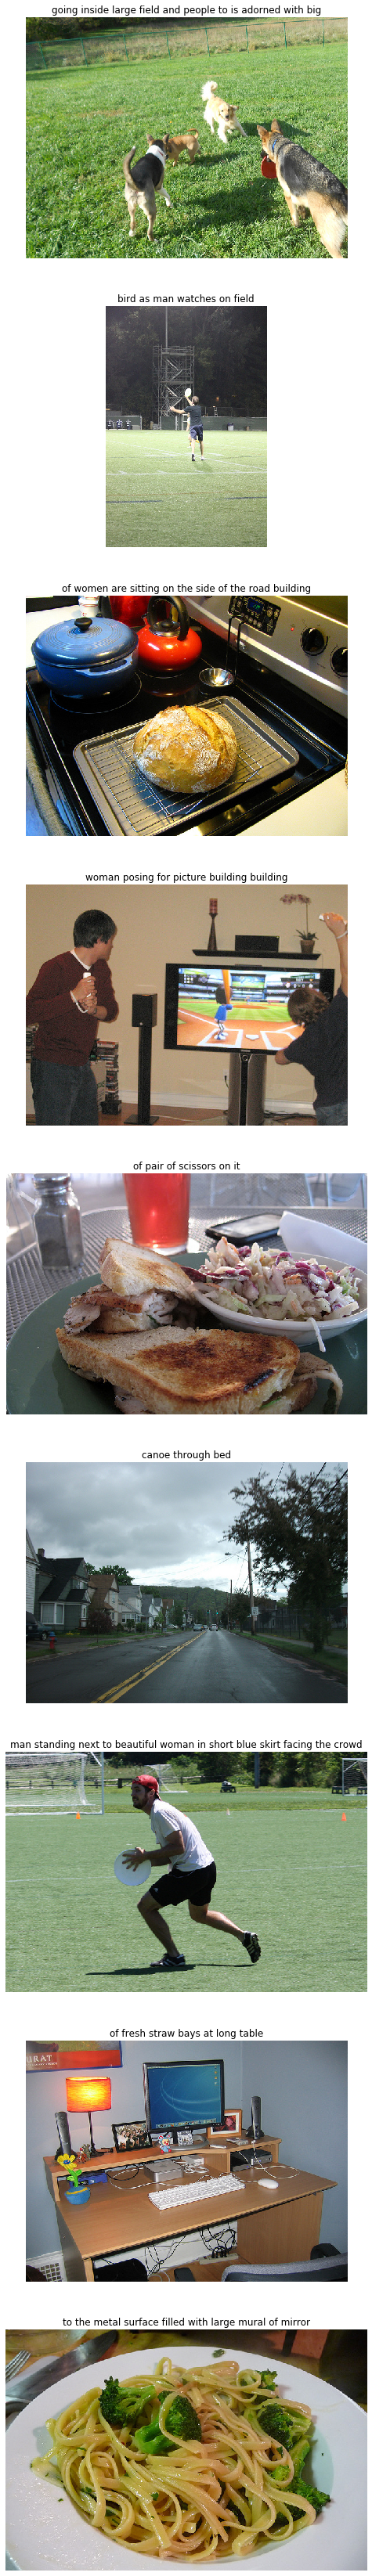

In [83]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([256, 256], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


plt.figure(figsize=(10, 60))
imgs = list(data_loader.dataset.files.images.keys())
ids = np.random.randint(0, 5000, 9)

for j in range(9):
  img_path = 'Dataset/val2017/' + imgs[ids[j]]
  image = load_image(img_path, transform)
  image_tensor = image.to(device)

  # Generate an caption from the image
  feature = encoder(image_tensor)
  sampled_ids = decoder.sample(feature)
  sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

  # Convert word_ids to words
  sampled_caption = []
  words = data_loader.dataset.words
  for word_id in sampled_ids:
      word = words.id2word[word_id]
      # if word == 'END':
      #     break
      if not word == 'UNK' and not word == 'START' and not word == 'END': 
          sampled_caption.append(word)
      
  sentence = ' '.join(sampled_caption)

  # Print out the image and the generated caption
  print (sentence)
  image = Image.open(img_path)
  plt.subplot(9, 1, j+1)
  plt.imshow(np.asarray(image))

  plt.title(sentence)
  plt.grid(False)
  plt.axis(False)

plt.show()